In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
#upload train
from google.colab import files
uploaded=files.upload()

Saving sign_mnist_train.csv to sign_mnist_train.csv


In [3]:
#upload test
from google.colab import files
uploaded_1=files.upload()

Saving sign_mnist_test.csv to sign_mnist_test.csv


In [4]:
train_df=pd.read_csv('sign_mnist_train.csv')
test_df=pd.read_csv('sign_mnist_test.csv')


In [5]:
#preproccessing
y_train = train_df['label'].values
y_test = test_df['label'].values
X_train = train_df.drop('label', axis=1).values
X_test = test_df.drop('label', axis=1).values

X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Training data shape: (27455, 28, 28)
Training labels shape: (27455,)


In [6]:
class SignLanguageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = image.astype(np.float32) / 255.0
        image = np.expand_dims(image, axis=0)
        image_tensor = torch.tensor(image, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return image_tensor, label_tensor

train_dataset = SignLanguageDataset(X_train, y_train)
test_dataset = SignLanguageDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
class SignLanguageCNN(nn.Module):
    def __init__(self):
        super(SignLanguageCNN, self).__init__()

        # Update to 25 classes as labels range from 0 to 24 (excluding 9)
        self.num_classes = 25


        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.dropout = nn.Dropout(0.5)


        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, self.num_classes)

    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))


        x = self.pool2(F.relu(self.conv2(x)))


        x = x.view(-1, 32 * 7 * 7)


        x = self.dropout(x)


        x = F.relu(self.fc1(x))


        x = self.fc2(x)
        return x

In [8]:
model = SignLanguageCNN()
EPOCHS = 10
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:



        optimizer.zero_grad()


        outputs = model(images)


        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {epoch_loss:.4f}")

print("Training finished!")

Epoch 1/10, Training Loss: 1.4414
Epoch 2/10, Training Loss: 0.3954
Epoch 3/10, Training Loss: 0.2061
Epoch 4/10, Training Loss: 0.1268
Epoch 5/10, Training Loss: 0.0895
Epoch 6/10, Training Loss: 0.0656
Epoch 7/10, Training Loss: 0.0508
Epoch 8/10, Training Loss: 0.0393
Epoch 9/10, Training Loss: 0.0352
Epoch 10/10, Training Loss: 0.0285
Training finished!


In [9]:

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 94.88%


In [16]:
def visualize_cnn_prediction(index, model, dataset):
  import matplotlib.pyplot as plt


  label_to_alphabet = {
      0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E',
      5: 'F', 6: 'G', 7: 'H', 8: 'I',
      10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O',
      15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T',
      20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
  }


  image_tensor, true_label_tensor = dataset[index]


  model.eval()

  with torch.no_grad():

      output = model(image_tensor.unsqueeze(0))
      _, predicted = torch.max(output.data, 1)

  predicted_label_num = predicted.item()
  actual_label_num = true_label_tensor.item()

  predicted_label_char = label_to_alphabet.get(predicted_label_num, f'Unknown ({predicted_label_num})')
  actual_label_char = label_to_alphabet.get(actual_label_num, f'Unknown ({actual_label_num})')

  plt.figure(figsize=(5,5))
  plt.title(f"Predicted: {predicted_label_char} | Actual: {actual_label_char}")

  plt.imshow(image_tensor.squeeze(0).numpy(), cmap="gray")
  plt.axis("off")
  plt.show()

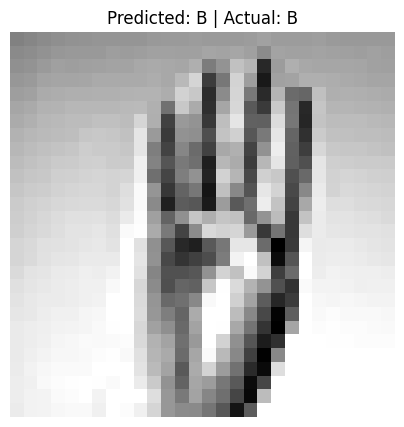

In [27]:
visualize_cnn_prediction(741, model, test_dataset) 